In [1]:
import pandas as pd
import numpy as np
import glob as gb
import os
import photonics.photodiode as fl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib notebook

In [48]:
dataf ='../Data/T2 Sweeps/'

<IPython.core.display.Javascript object>


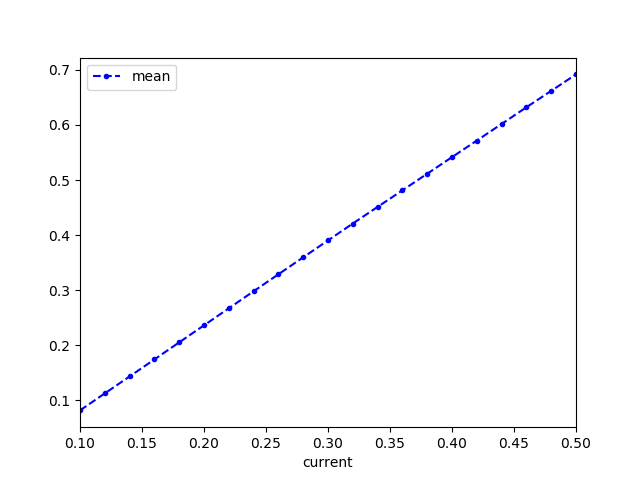

In [49]:
directory = dataf + 'intensity_vs_current/'
df = pd.read_hdf(directory + 'analysis.h5')
ax = df.plot('current', 'mean', style=['b.--'])  # , yerr='std'
fig = ax.get_figure()
fig.savefig(directory + 'intensity.png')

In [50]:
x = df['current']
y = df['mean']

fn = lambda x, m, c: m * x + c 

# Fit using Levenberg-Marquardt algorithm
popt, pcov = curve_fit(fn, x, y, p0=[1, min(y)])
# Error in coefficients to 1 std.
perr = np.sqrt(np.diag(pcov))
popt

array([ 1.52749336, -0.06966907])

# Rise and decay times

In [51]:
directory = dataf + 'decay_vs_current/'
files = gb.glob(directory + '/Plots/*.npz')

<IPython.core.display.Javascript object>


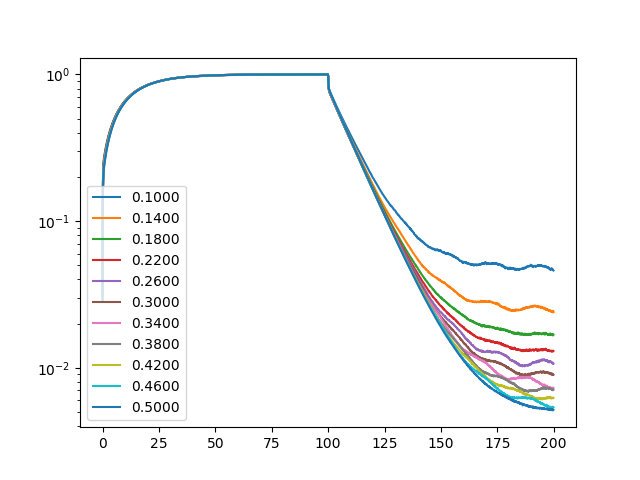

In [52]:
fig, ax = plt.subplots()
for f in files:
    data = np.load(f)
    x =  data['t']
    y =  data['data']
    y /= max(y)
    
    current = os.path.basename(f)
    current = os.path.splitext(current)[0]
    ax.plot(x, y, label=current)
    ax.set_yscale('log')
plt.legend()
plt.savefig(directory + 'decays')

In [53]:
c = []
taus = []
tau_r = []
std = []
std_r = []

print('Current\ttau\tstd\ttau_r\tstd')
for f in files:
    data = np.load(f)
    x =  data['t']
    y =  data['data']
    
    current = os.path.basename(f)
    current = float(os.path.splitext(current)[0])
    c.append(current)
    
    # Fit decay
    pump= 100
    # Reject data while pump is on
    xnew, ynew = fl.reject_time(x, y, reject_start=pump, reject_end=0)
    # Fit a single exp. decay function
    popt, perr = fl.fit_decay(xnew, ynew, p0=[max(y), 10, min(y)], print_out=False)
#     popt, perr = fl.fit_decay2(xnew, ynew, p0=[max(y), 10, max(y), 0.1, min(y)], print_out=False)
    tau = popt[1]
    taus.append(tau)
    tau_std = perr[1]
    std.append(tau_std)
    
    # Fit rise time
    # Reject data while pump is off
    xnew, ynew = fl.reject_time(x, y, reject_start=0, reject_end=(x[-1]-pump))
    # Fit a single exp. decay function
    popt, perr = fl.fit_rise(xnew, ynew, p0=[max(y), 10, min(y)], print_out=False)
    tau_r.append(popt[1])
    std_r.append(perr[1])
    print('{:.2f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}'.format(current, tau, tau_std, popt[1], perr[1]))

Current	tau	std	tau_r	std
0.10	12.083	0.029	12.027	0.030
0.14	12.053	0.031	11.984	0.031
0.18	12.020	0.032	11.992	0.032
0.22	12.013	0.032	11.978	0.032
0.26	12.015	0.032	11.979	0.031
0.30	12.015	0.031	11.959	0.031
0.34	12.017	0.030	11.976	0.030
0.38	12.014	0.030	11.958	0.029
0.42	12.014	0.029	11.949	0.029
0.46	12.022	0.028	11.917	0.028
0.50	12.021	0.028	11.927	0.027


<IPython.core.display.Javascript object>


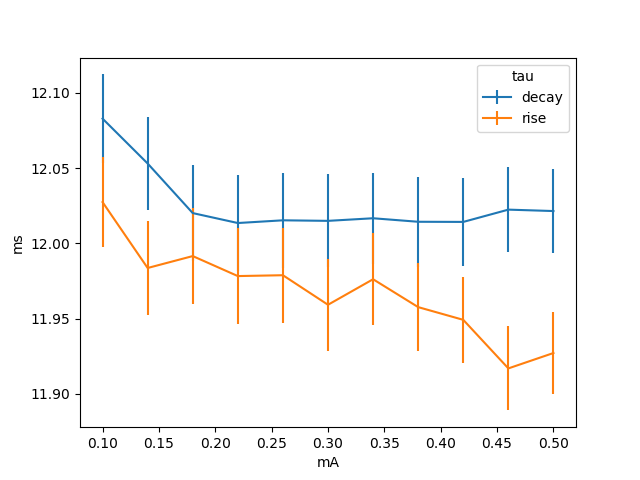

In [54]:
fix, ax = plt.subplots()
ax.errorbar(c, taus, yerr=std, label='decay')
ax.errorbar(c, tau_r, yerr=std_r, label='rise')
ax.set_xlabel('mA')
ax.set_ylabel('ms')
plt.legend(title='tau')
plt.savefig(directory + 'fits.png')

In [55]:
x = c
y = taus

fn = lambda x, m, c: m * x + c 

# Fit using Levenberg-Marquardt algorithm
popt, pcov = curve_fit(fn, x, y, p0=[1, min(y)])
# Error in coefficients to 1 std.
perr = np.sqrt(np.diag(pcov))
popt, perr

(array([ -0.10102618,  12.05657161]), array([ 0.04350307,  0.01416357]))

# Misc

In [15]:
from numpy import pi
c_erer=2.3E-39 / 2.5
n_q=8E18
n_er=2.17E20

# Decay rate without upconversion
w = 1e3 / popt[1]

w0 = w - 8 * pi * c_erer * n_er * n_q

# Radiative lifetiem
1e3/w0

23.363222513951477

In [12]:
c_erer_list = np.linspace(0, 1E-39, num=10000)
y = []

for c_erer in c_erer_list:
    w0 = w - 8 * pi * c_erer * n_er * n_q

    # Radiative lifetiem
    y.append(1e3/w0)

<IPython.core.display.Javascript object>


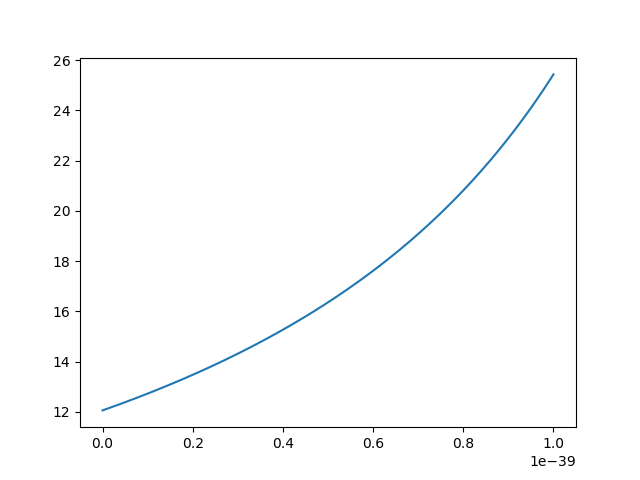

In [13]:
fig, ax = plt.subplots()
ax.plot(c_erer_list, y)

In [76]:
np.random.rand()

0.8004975843894864